# Looking at Clear Creek Stream Guage Data during spring runoff season

- API information is available at <https://waterservices.usgs.gov/rest/IV-Service.html#URLFormat>
- Data going back as far as October 1, 2007 are available for each site
- Timestamp returned by API is local (note the -6 at end, indicating that it is UTC-6). However, when converted using pd.to_datetime, it is changed to UTC. I fix this by putting data as index, and using localize>convert to set time zone to Mountain time.


In [1]:
# import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

In [2]:
# parameters for API request
base_url = 'http://waterservices.usgs.gov/nwis/iv/?'
#parameters = {'site': '06719505','format_out':'json','indent':'on','period':'P50D','variable':'00060',
#              'startDT':'2007-10-1','endDT':'2017-7-10'}

site = '06719505' # site number for Clear Creek in Golden
format_out = 'json'
indent = 'on' # indent json output for easier viewiing
#period = 'P50D' # last X days
variable = '00060' # discharge, cubic feet per second
startDT = '2007-10-1' 
endDT = '2017-7-10'

In [3]:
#request_url = base_url + 'site=' + site + '&format=' + format_out + '&indent=' + indent + '&period=' + period + '&variable=' + variable
request_url = base_url + 'site=' + site + '&format=' + format_out + '&indent=' + indent + '&startDT=' + startDT + '&endDT=' + endDT + '&variable=' + variable
request_url

'http://waterservices.usgs.gov/nwis/iv/?site=06719505&format=json&indent=on&startDT=2007-10-1&endDT=2017-7-10&variable=00060'

In [4]:
# get requested json
resp = requests.get(request_url)
#resp = requests.get(base_url, params=parameters)
js = resp.json()

In [5]:
# [value][timeSeries] returns a list of dicts (1 dict for each variable)
# length of this list will be # of variables
value_dict = js['value']['timeSeries']
len(value_dict)

1

In [6]:
# print all variables
for entry in value_dict:
    print(entry['variable']['variableName'])

Streamflow, ft&#179;/s


In [7]:
value_dict[0].keys()

dict_keys(['sourceInfo', 'variable', 'values', 'name'])

In [8]:
val_dict2 = value_dict[0]['values']
type(val_dict2)

list

In [9]:
# finally get to the actual observations
# returns another list of dicts, where each dict is one observation in the timeseries
ivar= 0
# get an actual value
val_dict2[ivar]['value'][11]['value']

'102'

In [10]:
# get the timestamp
TS = val_dict2[ivar]['value'][11]['dateTime']
pd.to_datetime(TS).tz_localize('UTC').tz_convert('US/Mountain')

Timestamp('2007-10-01 02:45:00-0600', tz='US/Mountain')

Extract entire timeseries

In [11]:
dict2 = val_dict2[ivar]['value']
dates = []
vals = []
for row in dict2:
    dates.append(row['dateTime'])
    vals.append(row['value'])
    
dates = pd.to_datetime(dates)

In [12]:
#dict2[0]['dateTime']

In [13]:
# not sure how to set keys as variable name, hardwire for now 
df = pd.DataFrame({'streamflow':vals},index=dates)
df['streamflow']=df.streamflow.astype('float64')
df.head()

,streamflow
2007-10-01 06:00:00,93.0
2007-10-01 06:15:00,98.0
2007-10-01 06:30:00,102.0
2007-10-01 06:45:00,102.0
2007-10-01 07:00:00,106.0


In [14]:
# make timezone in local (Mountain) time. The request actually returns data in local time, but 
# when read w/ pd_to_datetime, you have to reset it from UTC
df.index = df.index.tz_localize('UTC').tz_convert('US/Mountain')

# add year and yday (yday for comparing different years etc.)
df['yday'] = df.index.dayofyear
df['year'] = df.index.year
df['hour'] = df.index.hour

df.head()

,streamflow,yday,year,hour
2007-10-01 00:00:00-06:00,93.0,274,2007,0
2007-10-01 00:15:00-06:00,98.0,274,2007,0
2007-10-01 00:30:00-06:00,102.0,274,2007,0
2007-10-01 00:45:00-06:00,102.0,274,2007,0
2007-10-01 01:00:00-06:00,106.0,274,2007,1


## Plot data for all years

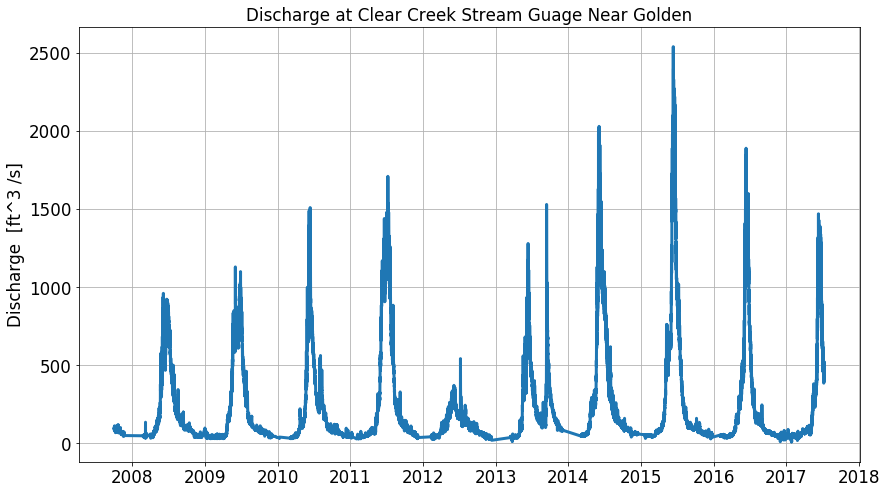

In [15]:
plt.figure(figsize=(14,8))
#plt.plot(df.date,df.streamflow)
plt.plot(df.streamflow)
plt.grid();
plt.ylabel('Discharge  [ft^3 /s]');
plt.title('Discharge at Clear Creek Stream Guage Near Golden');

## Look at 2017 (current year)

(0, 200)

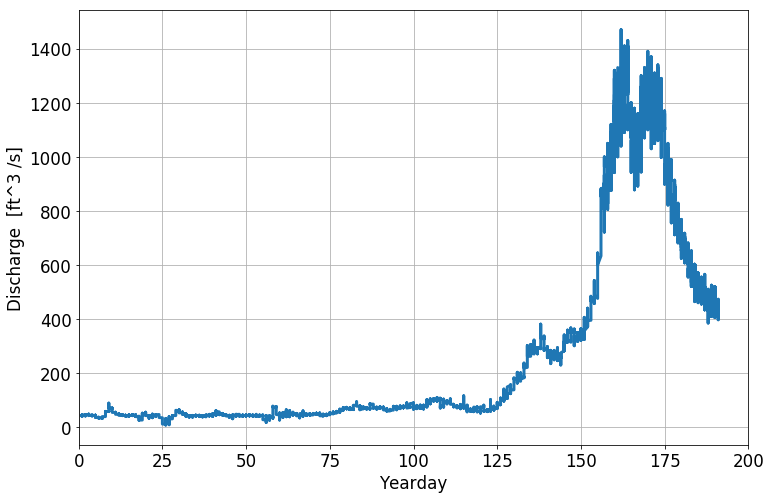

In [16]:
df2 = df.loc[df.year==2017]

plt.figure(figsize=(12,8))
plt.plot(df2.yday,df2.streamflow)
plt.grid()
plt.xlim((100,300))
plt.xlabel('Yearday');
plt.ylabel('Discharge  [ft^3 /s]');
plt.xlim(0,200)

## Zoom in on spring melt-off

(736482.0, 736510.0)

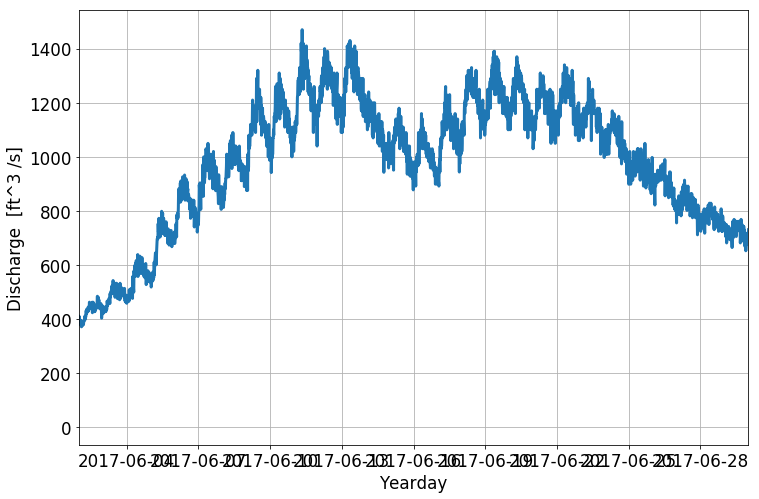

In [17]:
df2 = df.loc[df.year==2017]

plt.figure(figsize=(12,8))
plt.plot(df2.streamflow)
plt.grid()
#plt.xlim((100,300))
plt.xlabel('Yearday');
plt.ylabel('Discharge  [ft^3 /s]');
plt.xlim('2017-6-02','2017-06-30')

## Looks like there is some kind of daily cycle
- Looks like streamflow at Golden peaks around 7-9am?
- I would expect peak snowmelt to occur at miday/early afternoon?
- Does it take overnight for that signal to reach Golden?

(900, 1500)

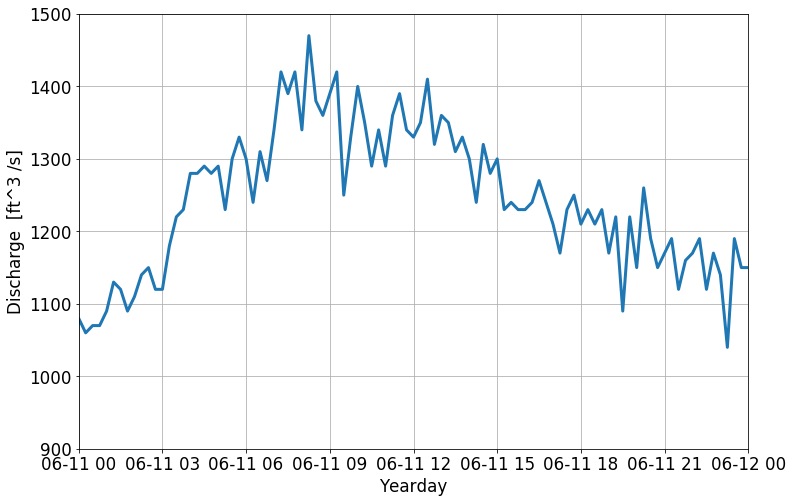

In [18]:
plt.figure(figsize=(12,8))
plt.plot(df2.streamflow)
plt.grid()
#plt.xlim((100,300))
plt.xlabel('Yearday');
plt.ylabel('Discharge  [ft^3 /s]');
plt.xlim('2017-6-11','2017-06-12')
plt.ylim(900,1500)

## Comparing Spring Melt-off for Different Years

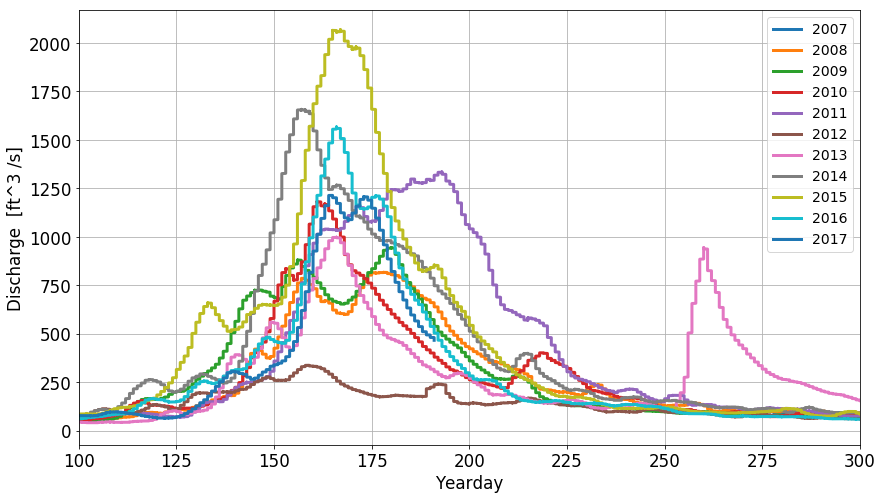

In [19]:

plt.figure(figsize=(14,8))
years = df.year.unique()
for year in years:
    df2 = df.loc[df.year==year]
    plt.plot(df2.yday,df2.streamflow.rolling(4*24*5).mean(),label=year)
    
plt.legend()
plt.grid()
plt.xlim((100,300))
plt.xlabel('Yearday');
plt.ylabel('Discharge  [ft^3 /s]');

## 2013 Floods

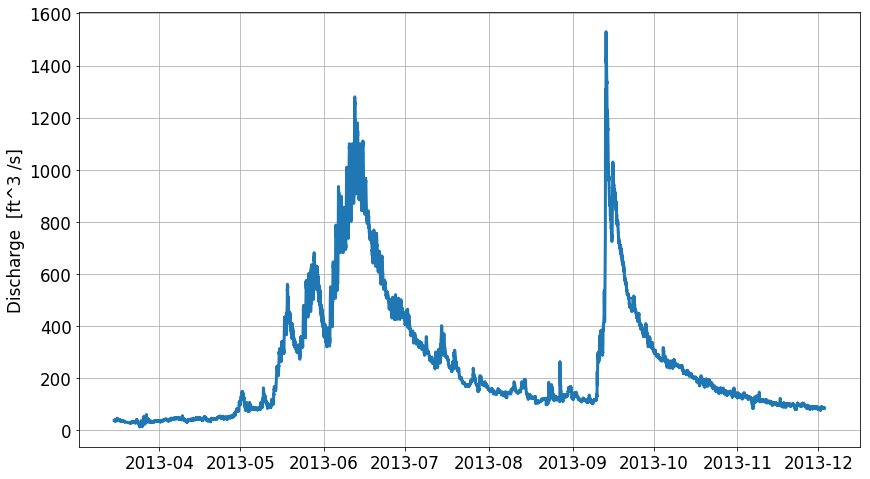

In [20]:
# look at just the 20013 floods
plt.figure(figsize=(14,8))
df2 = df.loc[df.year==2013]
plt.plot(df2.streamflow)
#plt.plot(df2.streamflow['2013-9-7':'2013-10-1'])
plt.grid()
plt.ylabel('Discharge  [ft^3 /s]')

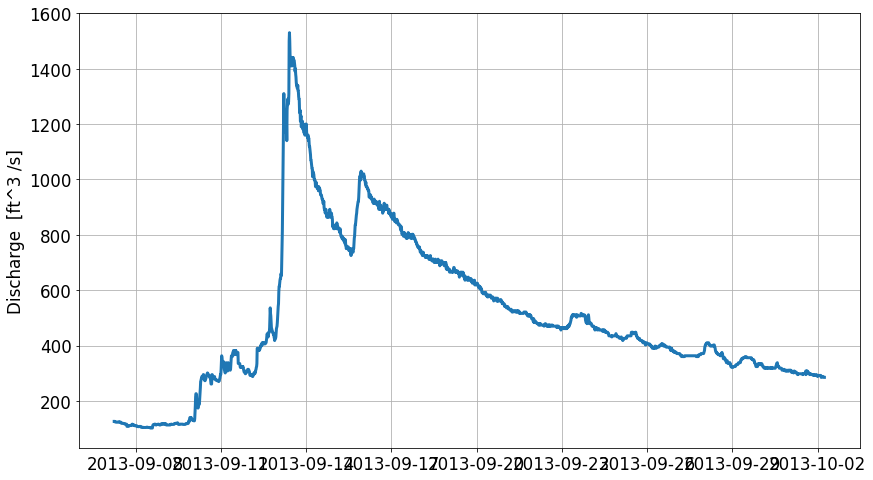

In [21]:
plt.figure(figsize=(14,8))
df2 = df.loc[df.year==2013]
#plt.plot(df2.streamflow)
plt.plot(df2.streamflow['2013-9-7':'2013-10-1'])
plt.grid()
plt.ylabel('Discharge  [ft^3 /s]')

## Look how fast it rose!
- Discharge more than doubled in less than 3 hours

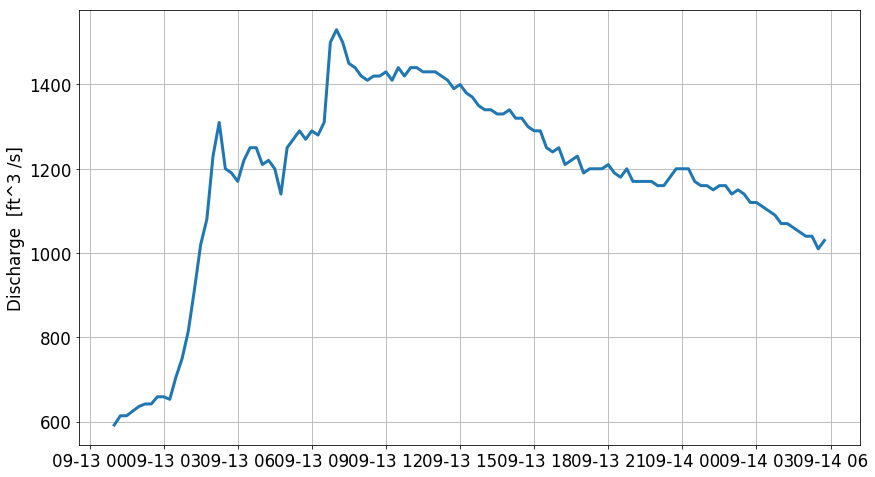

In [22]:
plt.figure(figsize=(14,8))
df2 = df.loc[df.year==2013]
#plt.plot(df2.streamflow)
plt.plot(df2.streamflow['2013-9-12 19:00:00':'2013-9-13'])
plt.grid()
plt.ylabel('Discharge  [ft^3 /s]');